
# HookNet - practical guide 



We designed HookNet specifically for high-resolution images. In this practical guide, we will see how the model can train on histopathology whole slide images.

HookNet is a multi-branch convolutional neural network and contains a context and a target branch. Thereby, the model expects two patches as input. One patch includes low-resolution context, and another concentric high-resolution patch, in which details are clearly visible. The resolution and shapes of these patches should be picked carefully as we defined some constraints to ensure that the model can correctly combine the features collected from both patches. Beside that, the model accepts several arguments which most have default values. This notebook will show how to pick the correct settings to make the model work properly. Furthermore, this notebook will show how to load wsi images and corresponding annotations, and how to sample input patches which will be used to train and apply HookNet


This notebooks uses the **wholeslidedata>=0.1.0** python package for loading wholeslide data (images and annotations) as well as and sampling patches. HookNet is a Keras model and has **tensorflow>=2.3.0** as a dependency. This notebook is designed to be ran in sequence (i.e., notebook cells are depending on previous notebooks cells)



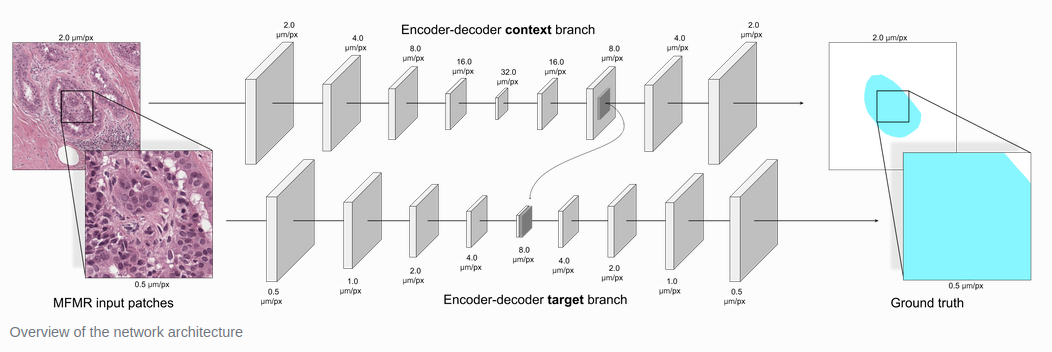



----
### 1. Installation and example data
- 1.1 installation
- 1.2 download example data

### 2. Whole slide data
- 2.1 whole slide image
- 2.2 whole slide annotation
- 2.3 batch iterator

### 3. Model training and inference
- 3.1 initialization (training)
- 3.2 training
- 3.3 initialization (inference)
- 3.4 inference


----
### 1 Installation and example data

#### 1.1 Installation

In [4]:
# !pip3 install hooknet # if tensorflow-gpu is not installed it will be installed as a dependency

# !pip install git+https://github.com/DIAGNijmegen/pathology-whole-slide-data@main  # for loading images,annotations and sampling
# install openslide-tools, ASAP or pyvips

# !pip3 install gdown           # for download downloading example data

#### 1.2 example data

In [1]:
# download example data
from exampledata import download_example_data
image_path, annotation_path = download_example_data()

print(f'Example image: {image_path}')
print(f'Example annotation: {annotation_path}')

Downloading...
From: https://drive.google.com/uc?id=1NefnQu3e0l4WR7Xb809gpVORXrKpJb0q
To: /tmp/TCGA-21-5784-01Z-00-DX1.tif
100%|██████████| 376M/376M [00:03<00:00, 121MB/s]  
Downloading...
From: https://drive.google.com/uc?id=1jkTp0IJHHpmLd1yDO1L3KRFJgm0STh0d
To: /tmp/TCGA-21-5784-01Z-00-DX1.xml
100%|██████████| 9.67k/9.67k [00:00<00:00, 7.94MB/s]

Example image: /tmp/TCGA-21-5784-01Z-00-DX1.tif
Example annotation: /tmp/TCGA-21-5784-01Z-00-DX1.xml


----
### 2 Wholeslidedata

In [2]:
from matplotlib import pyplot as plt
from matplotlib import patches
from plotutils import plot_mfmr_patches, plot_sample
from wholeslidedata.iterators import create_batch_iterator

#### 2.1 WholeSlideImage

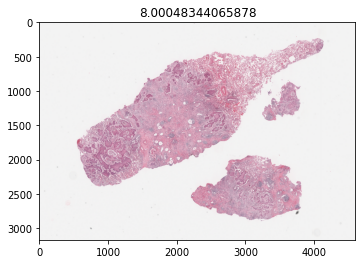

In [3]:
from wholeslidedata.image.wholeslideimage import WholeSlideImage

# spacing/resolution (4.0 um/px)
spacing_slide = 4.0

with WholeSlideImage(image_path) as wsi:
    downsampling = wsi.get_downsampling_from_spacing(spacing_slide)
    slide = wsi.get_slide(spacing_slide)
    
plt.title(f'{downsampling}')
plt.imshow(slide)
plt.show()

#### 2.2 WholeSlideAnnotation

#### 2.2.1 Annotations

annotation labels in slide: ['lymphocytes', 'stroma', 'tumor']


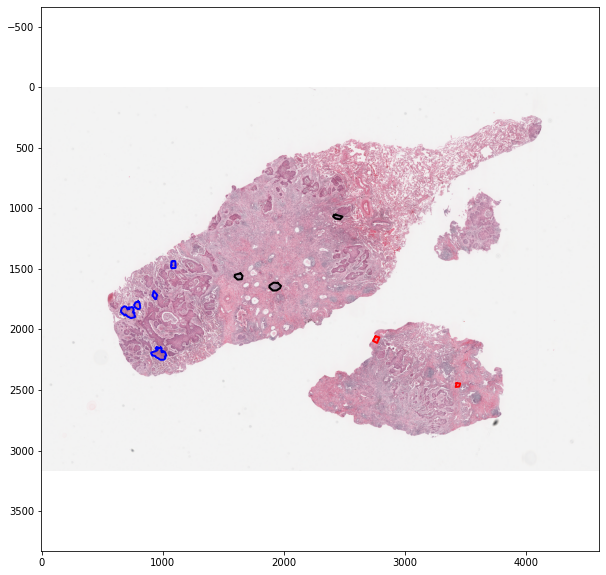

In [4]:
from wholeslidedata.annotation.wholeslideannotation import WholeSlideAnnotation
from wholeslidedata.visualization.plotting import plot_annotations

### create a whole-slide annotation
wsa = WholeSlideAnnotation(annotation_path)

# print labels of annotated regions (lymhocytes, stroma, tumor)
print(f'annotation labels in slide: {wsa.labels.names}')

### plot slide with annotations on top

# zip label_names with colors
colors = {label_name: label_color for label_name, label_color in zip(wsa.labels.names, ['black', 'red', 'blue'])}

fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(slide)
plot_annotations(annotations=wsa.annotations, ax=ax,scale=1/downsampling, color_map=colors)
plt.show()

#### 2.2.2 Multi field of view multi resolution patches

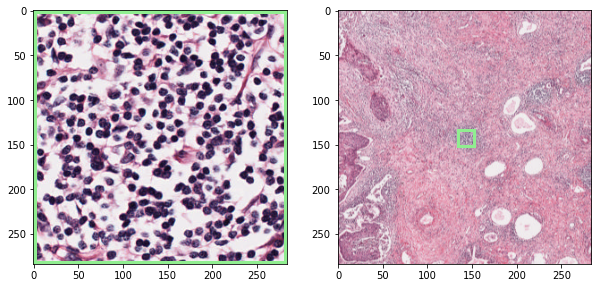

In [10]:
size = 284
context_spacing = 8.0
target_spacing = 0.5

annotation = wsa.annotations[0]
label = annotation.label.name
with WholeSlideImage(image_path) as wsi:
    downsampling = wsi.get_downsampling_from_spacing(context_spacing)
    context_patch = wsi.get_patch(*annotation.center, size, size, context_spacing)
    target_patch = wsi.get_patch(*annotation.center, size, size, target_spacing)

plot_mfmr_patches(target_patch, context_patch, size, downsampling)

#### 2.3 Batch Iterator

batch shapes:
x_shape: (1, 2, 284, 284, 3)
y_shape: (1, 2, 70, 70, 3)


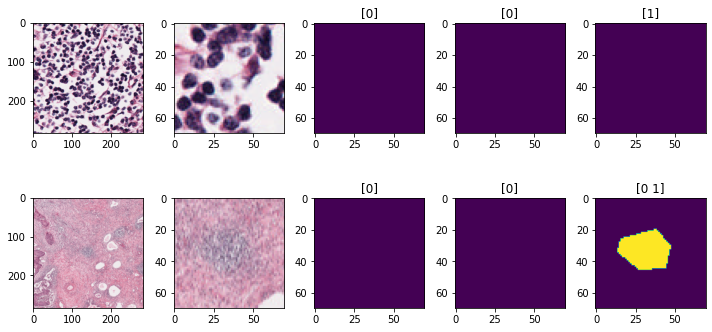

In [11]:
user_config = 'user_config.yml'
mode = 'training'
number_of_batches = 1
cpus=4

with create_batch_iterator(mode=mode, 
                           user_config=user_config, 
                           number_of_batches=number_of_batches, cpus=4) as training_iterator:
    
    for x_batch, y_batch, info in training_iterator:
        print('batch shapes:')
        print(f'x_shape: {x_batch.shape}')
        print(f'y_shape: {y_batch.shape}')
        plot_sample(x_batch[0], y_batch[0])

### 3. Model training and inference

     

In [1]:
from hooknet.models.tensorflowmodel import HookNet
import yaml
from tqdm.notebook import tqdm
from wholeslidedata.iterators import create_batch_iterator
from tensorflow import keras
import numpy as np
from wholeslidedata.visualization.plotting import plot_mask
from wholeslidedata.samplers.utils import one_hot_decoding
from wholeslidedata.samplers.utils import crop_data
from plotutils import plot_inference

#### 4.1 initialization (training)

In [2]:
""" Input Shapes
The input shape has to be chosen carfully, as there are some constraints to make the model wokr properly. 

First, Mhas to be chosen, such that all feature maps in the encoder path have an even size before each pooling layer. Introduced initially 
"""


input_shape = [[284,284, 3], [284,284, 3]]
hook_indices = [0,4]
n_classes=3

hooknet = HookNet(input_shape=input_shape, 
                  hook_indices=hook_indices,
                  n_classes=n_classes)

#### 4.2 Training

  0%|          | 0/200 [00:00<?, ?it/s]

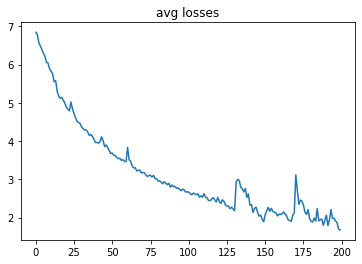

In [14]:
avg_losses = []
repeats = 200
number_of_batches = 10
with create_batch_iterator(mode='training', user_config='./user_config.yml', 
                           number_of_batches=number_of_batches, cpus=4) as training_iterator:
    
    for repeat in tqdm(range(repeats)):
        losses = []
        for x_batch, y_batch, info in training_iterator:

            # transpose batchsize and patches
            x_batch = list(x_batch.transpose(1,0,2,3,4))
            y_batch = y_batch.transpose(1,0,2,3,4)[0]

            out = hooknet.train_on_batch(x=x_batch, y=y_batch, return_dict=True)
            losses.append(out['loss'])
        avg_losses.append(np.mean(losses))

        
hooknet.save_weights('./hooknet_weights.h5')
keras.backend.clear_session()
plt.title('avg losses')
plt.plot(avg_losses)
plt.show()

#### 4.3 initialization (inference)

In [4]:
number_of_batches = 6
training_iterator = create_batch_iterator(mode='training', 
                           user_config='./inference_user_config.yml', 
                           number_of_batches=number_of_batches, cpus=4)

input_shape = [[1244,1244, 3], [1244,1244, 3]]
hook_indices = [0, 4]
n_classes=3
model_weights = './hooknet_weights.h5'

inference_hooknet = HookNet(input_shape=input_shape,
                            hook_indices=hook_indices,
                            n_classes=n_classes,
                            model_weights='./hooknet_weights.h5')

loading weights... ./hooknet_weights.h5


#### 4.4 inference

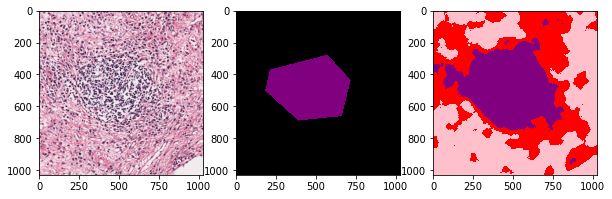

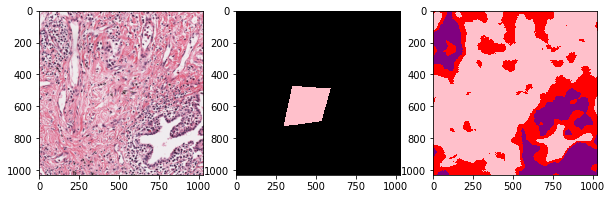

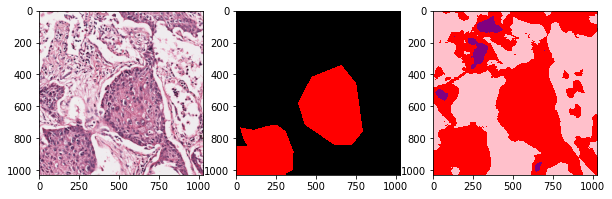

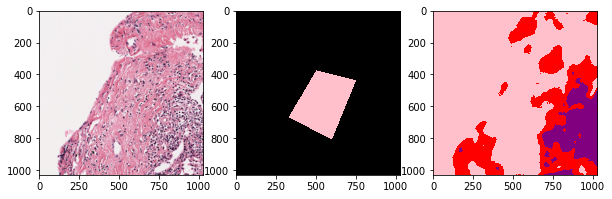

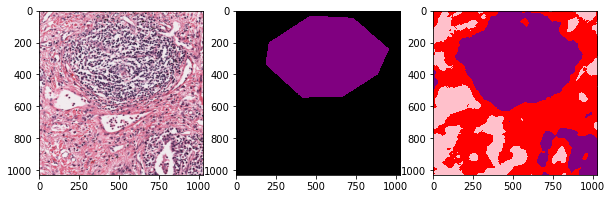

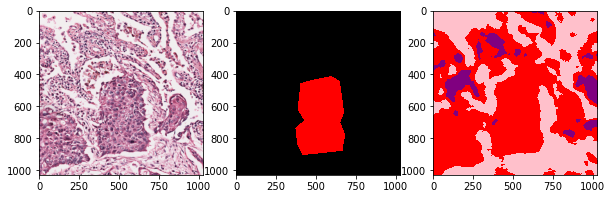

In [5]:
for x_batch, y_batch, info in training_iterator:
    x_batch = list(x_batch.transpose(1,0,2,3,4))
    predictions = inference_hooknet.predict_on_batch(x_batch)
    patch = crop_data(x_batch[0][0], inference_hooknet._out_shape[:2])
    plot_inference(patch, y_batch[0][0], predictions[0])